<a href="https://colab.research.google.com/github/J-Milando-10/STA-365-Homework/blob/main/STA365_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW4
JORDAN MILANDO
1006538873

In [1]:
import numpy as np
import pymc as pm
from scipy import stats
import matplotlib.pyplot as plt

PART 1 and 2

In [50]:
np.random.seed(341688)

mu_0,sigma_0 = 0,10
n = 100
loc_true,scale_true,df_true = 10,2,15 #WANT TO DISCOVER THE LAST 3
# True values data will be from... IRL, we don't know these values

x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)
# Data from location-scale-t distribution

with pm.Model() as HMC_LEC:

  #assume the following 3 priors for parameters
  mu = pm.Normal("mu", mu = mu_0, sigma = sigma_0)
  tau = pm.HalfNormal('tau', tau = 5) #scale is given
  nu = pm.DiscreteUniform('nu', lower = 1, upper = 101)


  # likelihood where observed information enters into the model
  obs = pm.StudentT("obs", mu= mu, nu = nu, lam = tau, observed=x)


SEED = [20100420, 20134234] # random seeds for each of two run HMC chains

with HMC_LEC:
    idata1 = pm.sample(100, chains=2)
    idata2 = pm.sample(1000, chains=2)
    idata3 = pm.sample(5000, chains=2)



Note the zero number of divergences

In [51]:

import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Low': pm.summary(idata1)[:1]['ess_bulk']}),
 pd.DataFrame({'Low': pm.summary(idata1)[1:]['ess_bulk']}),
 pd.DataFrame({'mid': pm.summary(idata2)[:1]['ess_bulk']}),
 pd.DataFrame({'mid': pm.summary(idata2)[1:]['ess_bulk']}),
 pd.DataFrame({'high': pm.summary(idata3)[:1]['ess_bulk']}),
 pd.DataFrame({'high': pm.summary(idata3)[1:]['ess_bulk']})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Low,mid,high
mu,221.0,NaN,NaN
nu,4.0,NaN,NaN
tau,59.0,NaN,NaN
mu,NaN,2198.0,NaN
nu,NaN,5.0,NaN
tau,NaN,2040.0,NaN
mu,NaN,NaN,10138.0
nu,NaN,NaN,8.0
tau,NaN,NaN,7980.0


We see for DF Parameter nu we see that as sample size increases the effective
sample size is still roughly the same despite the other 2 parameters effective
sample size increasing with sample size

PART 2

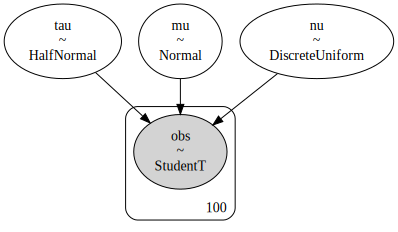

In [52]:
pm.model_to_graphviz(HMC_LEC)

Acceptance Rate


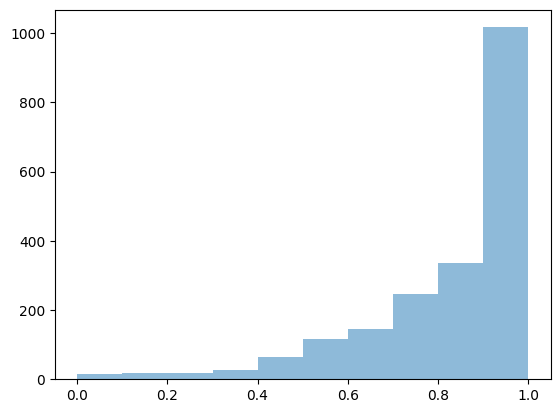

In [53]:
import matplotlib.pyplot as plt
plt.hist(idata2.sample_stats.acceptance_rate.values.flatten(), alpha=0.5);

Convergence Measures

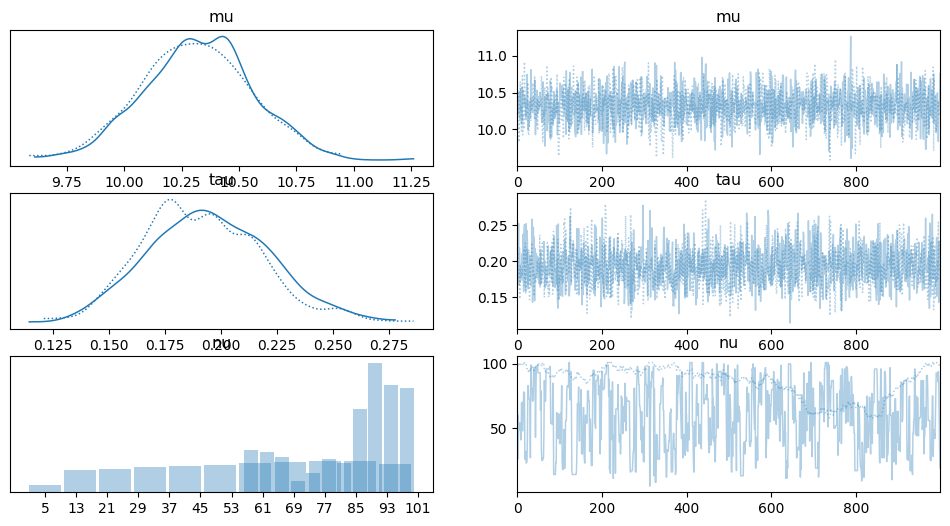

In [54]:
import arviz as az
az.plot_trace(idata2, var_names=["mu", "tau", "nu"]);

We can see from the trace plots that the mu and tau are fairly similar
indicating convergence, however for nu we do not see this and the trace plot
is not close to eachother bc it clearly has a different uniform parameter.
this is also clear from the plots on the right, the mu and tau has very similar because we do not see any sticky or poor mixing so we shouldnt be higly dependant or constantly rejecting/accepting markov chains. however for nu we see that there is clearly sticky and poor mixing indicating the parameter nu is highly dependant and constantly accepting markov chains

plots where as nu has 2 very distinct plots.

PART 3

In [55]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

# As is seen above, there are many divergences because the specification above
# induces high curature in the energy, but the following alternative
# parameterization alleviates this problem.

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!




Note how the divergences are way less for the non-centred sampling

Effective Sample sizes

In [56]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


Note hpw the effective sample size for non-centred is far larger than for centred

Acceptance Rates

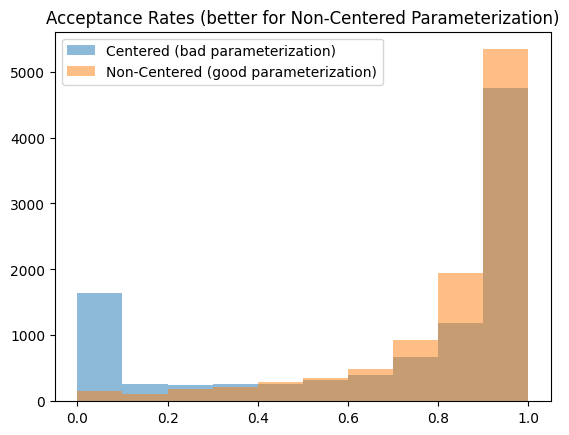

In [57]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();

Note how non-centred parameterization is almost always higher than the centred

Convergence Measures (centred)

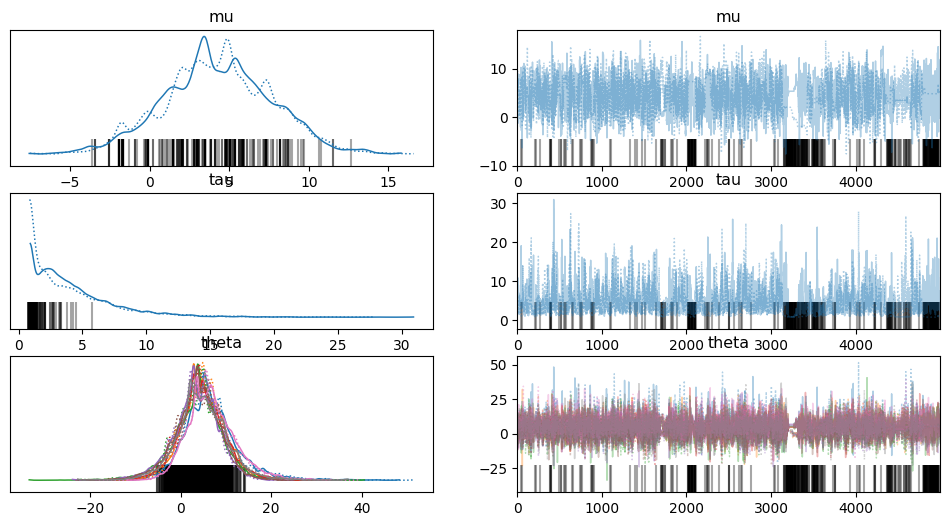

In [58]:
import arviz as az
az.plot_trace(fit_C, var_names=["mu", "tau", "theta"]);

overall the traceplot for mu is is not as strong indication a lack of convergence in where the peaks are however the value do converge in a broader pattern. we also see no signes of dependance or poor mixing.

for the tau parameter we see slighly stronger convergence than mu but we see some evidence of dependance and sticky chain albeit weak evidence

the theta parameter looks to show strong evidence of convergence and no evidence of poor mixing or sticky mixing

Convergence Measures (non-centred)

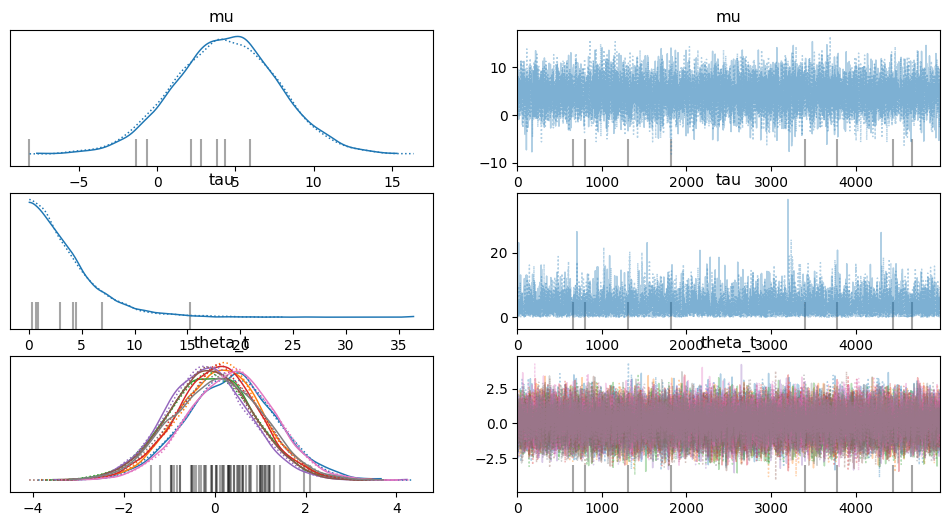

In [59]:
import arviz as az
az.plot_trace(fit_NC, var_names=["mu", "tau", "theta_t"]);

Overall for all three parameter, under the non-centred parameterization there is much stronger evidence of convergence than its centred parameter, as well as no evidence of poor or sticky mixing. except for tau, there may be evidence of sticky mixing by constantly rejecting the markov chains

PART 3 Subsection 2

from the perspective of curvature of the energy function, the uncentred parameterization performs better than the centred parameterization because non-centred parematers had higher acceptance rates causing less curvatature in the energy function. the non-centred parameter naturally also would have lower autocorrelation. these 2 facts allow for less computationally expensive proposals and hence better.

PART 4

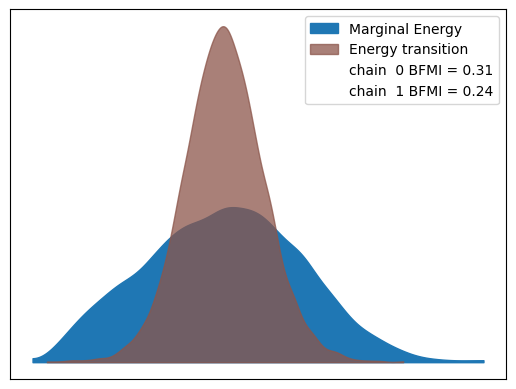

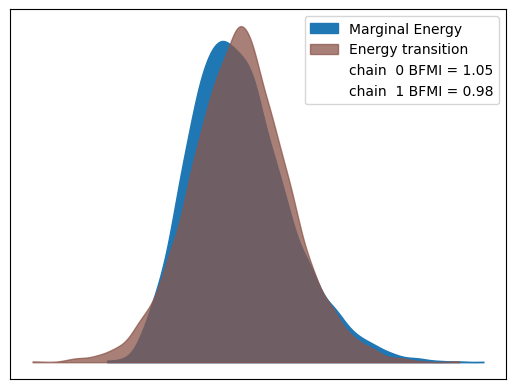

In [60]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

Ideally we want the 2 graphs to be similar, and we can see in the first plot which represents the centred parameters the 2 distributions are not centred at all indicating poor effectivness of the algorithm.

for the second plot which represents the non-centred that the two distributions are very similar and this indicates effectivness of the algorithm.

this diagnosis supports my conclusions in part 3 as notes on the various inference plots.